In [9]:
cd /mnt/md0/towards-threshold-invariance-in-defining-hippocampal-ripples

/mnt/md0/towards-threshold-invariance-in-defining-hippocampal-ripples


## Import libraries

In [1]:
import random
import sys

sys.path.append(".")

%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import mngs
import numpy as np
import ripple_detector_CNN
import torch
import utils
from scipy.signal import resample_poly

## Functions

In [2]:
def plot_LFP_trace(
    lfp_1ch_cropped,
    lfp_timepoints_sec,
    rip_sec_df,
    lfp_start_sec=0,
    plt_start_sec=4,
    plt_dur_sec=6,
    ylim=(-1050, 1050),
):

    """
    lfp_start_sec  # 819
    plt_start_sec  # 872
    plt_end_sec  # 875
    plt_dur_sec  # 3

    _plt_start_pts # 53000
    _plt_end_pts # 56000
    """

    ## Prepares the figure
    fig, ax = plt.subplots()

    ## Determines periods to show
    plt_end_sec = plt_start_sec + plt_dur_sec

    _plt_start_pts = (plt_start_sec - lfp_start_sec) * SAMP_RATE_TGT
    _plt_end_pts = _plt_start_pts + plt_dur_sec * SAMP_RATE_TGT
    # plt_start_sec = plt_start_sec

    # plt_start_pts = plt_start_sec * SAMP_RATE_TGT
    # plt_end_pts = plt_end_sec * SAMP_RATE_TGT

    ## Limits LFP
    # lfp_plt = lfp_1ch_cropped[plt_start_pts:plt_end_pts]
    lfp_plt = lfp_1ch_cropped[_plt_start_pts:_plt_end_pts]

    ## Limits timepoints
    # x_sec = np.arange(len(lfp_1ch_cropped)) / SAMP_RATE_TGT
    # x_plt_sec = x_sec[plt_start_pts:plt_end_pts]
    # x_plt_sec = x_sec[_plt_start_pts:_plt_end_pts]
    x_plt_sec = lfp_timepoints_sec[_plt_start_pts:_plt_end_pts]

    ## Limits ripple data frame
    rip_sec_df_plt = rip_sec_df[
        (plt_start_sec <= rip_sec_df["end_sec"])
        & (rip_sec_df["start_sec"] <= plt_end_sec)
    ]
    rip_sec_df_plt.loc[rip_sec_df_plt.index[-1], "end_sec"].clip(0, plt_end_sec)

    ## raw LFP trace
    ax.plot(
        x_plt_sec,
        lfp_plt,
        label="Raw LFP trace of the hippocampal CA1",
        linewidth=0.2,
        color="black",
    )

    ## Ripples
    for i_rip, rip_i in rip_sec_df_plt.iterrows():

        ## Colored areas indicating ripples (blue) or burst ones (gray).
        color_str = "blue" if not np.isnan(rip_i["ripple_conf"]) else "gray"
        color = mngs.plt.colors.to_RGBA(
            color_str,
            alpha=0.2,
        )
        ax.axvspan(
            rip_i.start_sec,
            rip_i.end_sec - 1.0 / SAMP_RATE_TGT,
            color=color,
            zorder=1000,
        )

        ## Shows ripple confidences as text
        # ylim = (int(ax.get_ylim()[0]), int(ax.get_ylim()[1]))
        
        y_base = 0.8 * ylim[1]
        y_fluctuation = 0.2 * random.randint(*ylim)
        rip_i_center = (rip_i["start_sec"] + rip_i["end_sec"]) / 2


        ripple_conf_str = str(round(rip_i["ripple_conf"], 2))
        ripple_conf_str = None if ripple_conf_str == "nan" else ripple_conf_str

        ax.text(
            rip_i_center,
            y_base + y_fluctuation,
            ripple_conf_str,
            horizontalalignment="center",
            verticalalignment="center",
        )

    ## Sets axes, ticks, labels, titles
    ax = mngs.plt.ax_set_n_ticks(ax)
    ax.set_ylabel(f"Amplitude [$\mu$V]")
    ax.set_xlabel("Time [sec]")
    ax.set_title("Represented ripple events with confidence values")
    ax.set_ylim(*ylim)

    single_patch = mpatches.Patch(
        color=mngs.plt.colors.to_RGBA("blue", alpha=0.2),
        label="single (values: confidence for ripples)",
    )
    burst_patch = mpatches.Patch(
        color=mngs.plt.colors.to_RGBA("gray", alpha=0.2), label="burst"
    )
    ax.legend(handles=[single_patch, burst_patch], loc="lower left")
    # fig.show()
    return fig


## Sets tee for logging

In [3]:
sys.stdout, sys.stderr = mngs.general.tee(sys)


Standard Output/Error are going to be logged in the followings: 
  - /tmp/ipykernel_944476/669020618/log/stdout.log
  - /tmp/ipykernel_944476/669020618/log/stderr.log




## Fixes random seeds

In [4]:
mngs.general.fix_seeds(np=np, random=random, torch=torch)


Random seeds have been fixed as 42



Prepares unseen signal

In [5]:
## Parameters
SAMP_RATE_TGT = 1000

## Loads unseen signal (mouse CA1 LFP from the CRCNS th1 dataset; https://crcns.org/data-sets/thalamus/th-1)
LPATH_EEG = "./data/th-1/data/Mouse12-120806/Mouse12-120806.eeg"
print(f"\nLoading {LPATH_EEG}\n")
LFPs_1250Hz, prop_dict = utils.pj.load.th_1(
    lpath_eeg=LPATH_EEG, start_sec_cut=0, dur_sec_cut=-1
)
# LFPs_1250Hz.shape
# (5, 27966750)


## Downsamples the signal from 1250 to 1000 Hz
LFPs_1kHz = resample_poly(LFPs_1250Hz, 4, 5, axis=1).astype(np.float32)
# LFPs_1kHz.shape
# (5, 22373400)


## Use only a part of signal for the computational reason
i_ch = random.randint(0, len(LFPs_1kHz) - 1)
lfp_start_sec = random.randint(0, int(LFPs_1kHz.shape[-1] / SAMP_RATE_TGT - 1))
LFP_DUR_SEC = 50 * 60  # 50 min
lfp_end_sec = lfp_start_sec + LFP_DUR_SEC

lfp_dt_sec = float(1 / SAMP_RATE_TGT)
lfp_timepoints_sec = np.arange(lfp_start_sec, lfp_end_sec, lfp_dt_sec).round(3)
lfp_1ch_cropped = LFPs_1kHz[i_ch][:, np.newaxis][
    lfp_start_sec * SAMP_RATE_TGT : lfp_end_sec * SAMP_RATE_TGT
]
# lfp_1ch_cropped.shape
# (3000000, 1)



Loading ./data/th-1/data/Mouse12-120806/Mouse12-120806.eeg



FileNotFoundError: [Errno 2] No such file or directory: './data/th-1/data/Mouse12-120806/Mouse12-120806.eeg'

## Estimates ripple probabilities using RippleDetectorCNN

In [6]:
rdCNN = ripple_detector_CNN.RippleDetectorCNN(
    lfp_1ch_cropped,
    lfp_timepoints_sec,
    window_size_pts=400,
    samp_rate=SAMP_RATE_TGT,
)
rip_sec_df = rdCNN.detect_ripple_candidates()
checkpoints = mngs.general.load(
    "./ripples/detect_ripples/CNN/train_FvsT/checkpoints/mouse_test#01_epoch#000.pth"
)
# This weight file is included in the repository. To clone or download it, might require git-LFP is installed. Of course, other four weights (*/mouse_test#0?_epoch#000.pth) will work as well.
rip_sec_df_with_estimated_ripple_conf = rdCNN.estimate_ripple_proba(
    checkpoints=checkpoints
)


NameError: name 'lfp_1ch_cropped' is not defined

## Visualizes the results


Matplotilb has been configured as follows:
{'figure.dpi': 300, 'savefig.dpi': 300, 'figure.figsize': '(24.0, 12.0) [cm]', 'font.size': 8, 'axes.labelsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.titlesize': 8, 'legend.fontsize': 7, 'pdf.fonttype': 42, 'ps.fonttype': 42, 'axes.spines.top': True, 'axes.spines.right': True}.



NameError: name 'rdCNN' is not defined

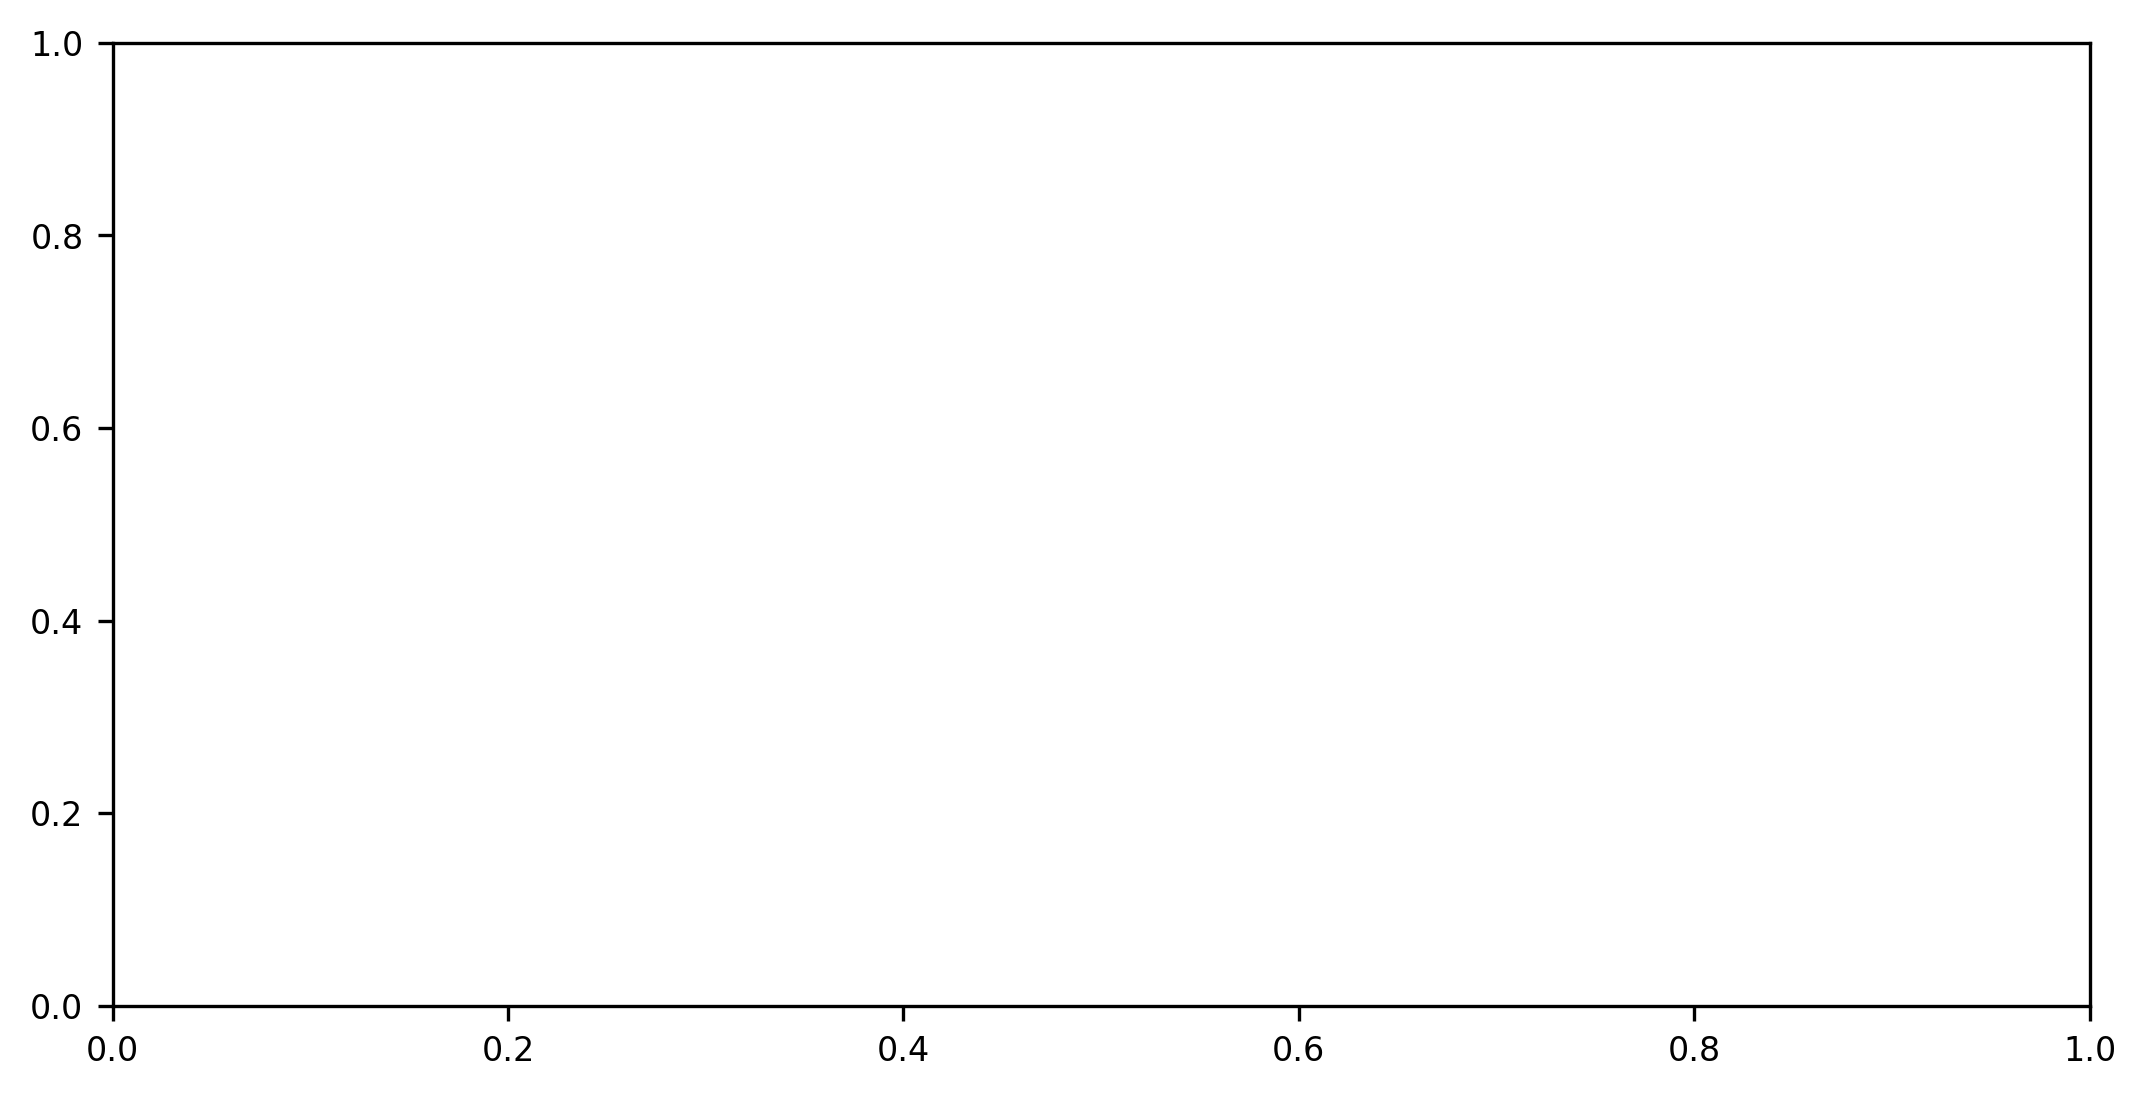

NameError: name 'rdCNN' is not defined

In [7]:
mngs.plt.configure_mpl(
    plt,
    dpi=300,
    figsize=(24, 12),
    fontsize=8,
    labelsize=8,
    legendfontsize=7,
    hide_spines=False,
)

fig, ax = plt.subplots()
ax.hist(rdCNN.rip_sec_df["ripple_conf"], bins=30)
ax.set_ylabel("# of ripple candidates")
ax.set_xlabel("Ripple confidence estimated by the trained CNN")
LFP_LENGTH_SEC = lfp_end_sec - lfp_start_sec
n_ripples = len(rip_sec_df)
ax.set_title(
    f"Calculated from {LFP_LENGTH_SEC}-sec LFP trace\n(n={n_ripples} ripple candidates in total)"
)
ax = mngs.plt.ax_set_n_ticks(ax, n_xticks=5)
mngs.general.save(
    fig, f"histogram_ripple_candidates_{lfp_start_sec}-{lfp_end_sec}s.png"
)
# fig.show()
# plt.close()

mngs.plt.configure_mpl(
    plt,
    dpi=300,
    figsize=(24, 12),
    fontsize=8,
    labelsize=8,
    legendfontsize=7,
    hide_spines=True,
)


In [8]:
PLT_DUR_SEC = 5
for i_fig in range(30):
    random_plt_start_sec = random.randint(lfp_start_sec, lfp_end_sec - PLT_DUR_SEC)
    fig = plot_LFP_trace(
        lfp_1ch_cropped,
        lfp_timepoints_sec,
        rip_sec_df_with_estimated_ripple_conf,
        lfp_start_sec=lfp_start_sec,
        plt_start_sec=random_plt_start_sec,
        plt_dur_sec=PLT_DUR_SEC,
    )
    # fig.show()
    # _start = random_plt_start_sec
    # _end = _start + PLT_DUR_SEC
    # mngs.general.save(fig, f"example_trace_ch#{i_ch}_{_start}-{_end}s.png")
    # plt.close()

NameError: name 'lfp_start_sec' is not defined